# Project: Anomalous Lines in APOGEE Spectra (ALIAS)

## About this tutorial:

This tutorial focuses on plotting, normalizing, and comparing the spectra of 10 stars.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.io import fits
import scipy.interpolate
from scipy.interpolate import splev, splrep

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
file = '../spectra/allStar-dr17-synspec_rev1.fits'

In [4]:
tbl = Table.read(file)

# Inspecting solar-like stars within 300 pc

Stars within 300 pc with $BP - RP$ around 0.82 +/- 0.01, and $M_G$ between 5 and 4.

What's the difference between `GAIAEDR3_R_MED_PHOTOGEO` and `GAIAEDR3_R_HI_PHOTOGEO`?

In [22]:
n300pc = ((tbl['GAIAEDR3_R_HI_PHOTOGEO'] <= 300) & 
         (((tbl['GAIAEDR3_R_HI_PHOTOGEO'] - tbl['GAIAEDR3_R_MED_PHOTOGEO'])/tbl['GAIAEDR3_R_HI_PHOTOGEO']) < 0.01) &
         (tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'] < (0.82+0.01)) & 
         (tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'] > (0.82-0.01)) & 
         ((tbl['GAIAEDR3_PHOT_G_MEAN_MAG'] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'])+5) < 5) &
         ((tbl['GAIAEDR3_PHOT_G_MEAN_MAG'] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'])+5) > 4)
        )

print('This many stars within 300 pc have solar-like properties:', n300pc.sum())
print('This many stars within 300 pc with solar-like properties have an absolute G magnitude > 4.4 mag:', (tbl['LOGG'][n300pc] > 4.4).sum())

This many stars within 300 pc have solar-like properties: 1730
This many stars within 300 pc with solar-like properties have an absolute G magnitude > 4.4 mag: 907


Text(0, 0.5, 'log g (surface gravity)')

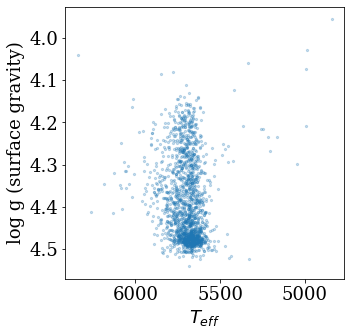

In [23]:
# an HR diagram of the stars in n300pc

plt.figure(figsize=(5,5))
plt.scatter(tbl['TEFF'][n300pc], 
            tbl['LOGG'][n300pc],
            s=5, alpha=0.25)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
# plt.xlim(8000,2000)
plt.xlabel('$T_{eff}$')
plt.ylabel('log g (surface gravity)')
#plt.savefig('hrd2.png',dpi=150,bbox_inches='tight')

In [24]:
# these are the files to pull for the stars in n300pc

tbl['FILE'][n300pc]

apStar-dr17-2M00030035+1554160.fits
apStar-dr17-2M00061847+1539108.fits
apStar-dr17-2M00091408+1445260.fits
apStar-dr17-2M00115214+8520020.fits
asStar-dr17-2M00124050-1948017.fits
apStar-dr17-2M00125570-1441121.fits
apStar-dr17-2M00164036+1612307.fits
apStar-dr17-2M00203029-0030022.fits
asStar-dr17-2M00241591-7717498.fits
apStar-dr17-2M00252721+1347329.fits
apStar-dr17-2M00275854+0002391.fits


# Inspecting individual spectra

Refer to the data model for individual spectra [here](https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/stars/TELESCOPE/FIELD/apStar.html#hdu1).

## Construct URLs for data

https://www.sdss.org/dr17/irspec/spectro_data/#ScienceArchiveServer(SAS)

In [27]:
# so we can construct URLs for data: https://www.sdss.org/dr17/irspec/spectro_data/#ScienceArchiveServer(SAS)

TELESCOPE = tbl['TELESCOPE'][n300pc]
FIELD = tbl['FIELD'][n300pc]
FILE = tbl['FILE'][n300pc]

u1 = 'https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/'

URL = np.array([], dtype=str)
for k in range(n300pc.sum()):
    URL = np.append(URL, u1 + TELESCOPE[k] + '/' + FIELD[k] + '/' + FILE[k])

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U81'), dtype('float64')) -> None

In [36]:
len(URL) # URLs to download individual spectra of the stars in n300pc

83

In [41]:
# command to download the spectra in terminal
for url in URL[:10]:
    print('curl -O '+url)

curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/107-46_MGA/apStar-dr17-2M00030035+1554160.fits
curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/107-46_MGA/apStar-dr17-2M00061847+1539108.fits
curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/107-46_MGA/apStar-dr17-2M00091408+1445260.fits
curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/N188/apStar-dr17-2M00115214+8520020.fits
curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/lco25m/066-79/asStar-dr17-2M00124050-1948017.fits
curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/090-75/apStar-dr17-2M00125570-1441121.fits
curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/111-47_MGA/apStar-dr17-2M00164036+1612307.fits
curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/107-62_MGA/apStar-dr17-2M00203029-0030022.fits
curl -O https:

# Opening the downloaded individual visit spectra

In [42]:
spectra_10 = tbl['FILE'][n300pc][:10]
spectra_10 # table of the file names of the 10 spectra

apStar-dr17-2M00030035+1554160.fits
apStar-dr17-2M00061847+1539108.fits
apStar-dr17-2M00091408+1445260.fits
apStar-dr17-2M00115214+8520020.fits
asStar-dr17-2M00124050-1948017.fits
apStar-dr17-2M00125570-1441121.fits
apStar-dr17-2M00164036+1612307.fits
apStar-dr17-2M00203029-0030022.fits
asStar-dr17-2M00241591-7717498.fits
apStar-dr17-2M00252721+1347329.fits


In [43]:
for spec_file in spectra_10:
    hdul = fits.open('../spectra/' + spec_file)
    print(len(Table.read(hdul)))
    # length of table corresponds to number of visits

2
2
2
14
3
5
2
3
5
3


# Plotting all 10 spectra

In [131]:
def reconstruct_wavelength_axis(hdul):
    wave = 10**(hdul[1].header['CRVAL1'] + (hdul[1].header['CDELT1'] * np.arange(sp.shape[1])))
    print('Individual spectra', spec_file, 'has', len(Table.read(hdul)), 'visits, CRVAL1 of', hdul[1].header['CRVAL1'], 'and CDELT1 of', hdul[1].header['CDELT1'])
    return wave

In [132]:
def percentile_normalization(wl, flux, bin_length, q):
    # create empty arrays to store data for finding the fit function
    flux_values = np.empty(0)
    wl_values = np.empty(0)
    
    # COMPUTE THE Q-TH PERCENTILE OF EACH BIN
    for bin_index in np.arange(0, len(wl), step = bin_length): # divide the flux and wl arrays into bins
        # in each bin, find the q-th percentile of the flux
        flux_in_bin = np.percentile(flux[bin_index: bin_index + bin_length], q, method='nearest') # 'nearest' method gives the closest data point
        flux_values = np.append(flux_values, flux_in_bin)
        # find the wavelength value corresponding to the q-th percentile of the flux
        wl_in_bin = wl[bin_index: bin_index + bin_length][np.where(flux[bin_index: bin_index + bin_length] == flux_in_bin)]
        wl_values = np.append(wl_values, wl_in_bin)
        
    # INTERPOLATE TO FIND THE FLUX FIT
    spl = splrep(wl_values, flux_values) # find the B-spline representation
    flux_fit = splev(wl, spl) # evaluate the B-spline

    # GET THE NORMALIZED FLUX
    normalized_flux = flux / flux_fit
    
    return flux_fit, normalized_flux

In [165]:
def flux_divided_by_median(flux):
    median_normalized_flux = flux / np.nanmedian(flux)
    return median_normalized_flux

Individual spectra apStar-dr17-2M00030035+1554160.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00061847+1539108.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00091408+1445260.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00115214+8520020.fits has 14 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra asStar-dr17-2M00124050-1948017.fits has 3 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00125570-1441121.fits has 5 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00164036+1612307.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00203029-0030022.fits has 3 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra asStar-dr17-2M00241591-7717498.fits has 5 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00252721+1347329.fits

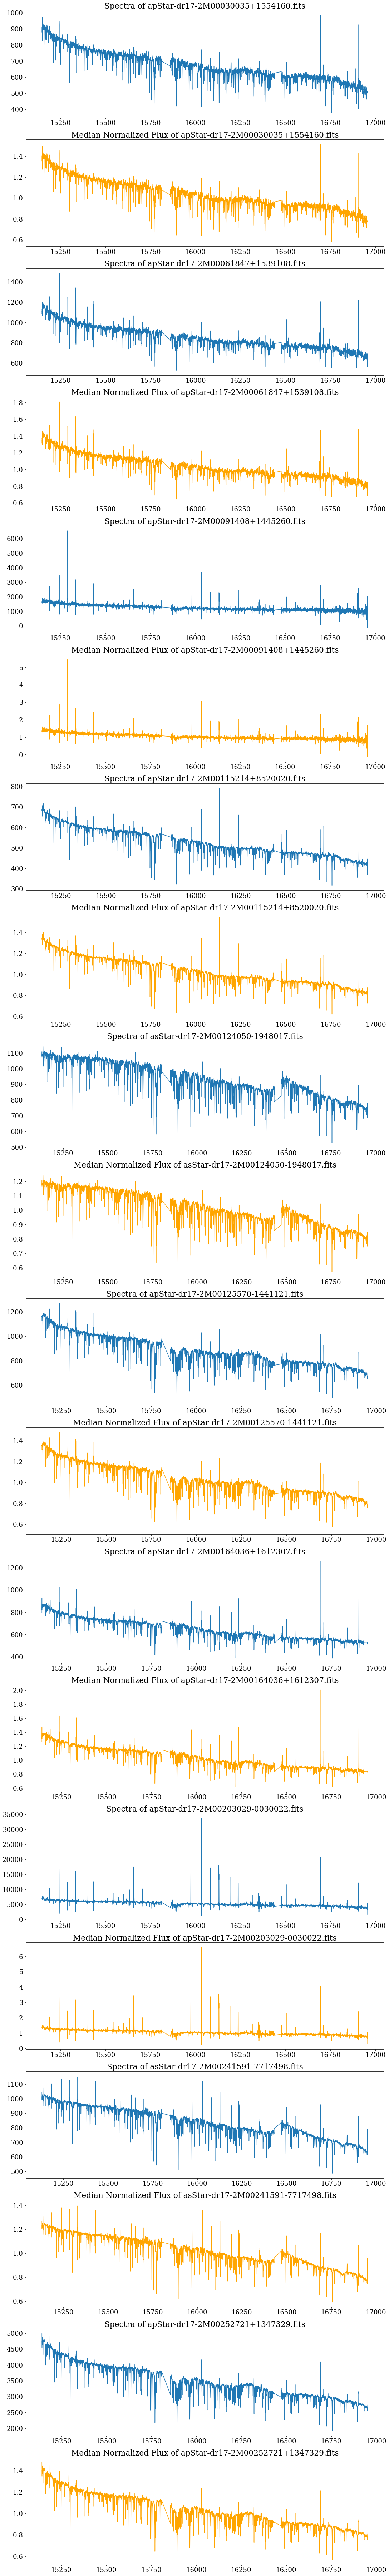

In [186]:
# flux normalization by dividing flux by median

fig, axes = plt.subplots(20, figsize=(15,5*20), constrained_layout=True)
i = 0

for spec_file in spectra_10:
    # get the spectra for each star
    hdul = fits.open('../spectra/' + spec_file)
    sp = hdul[1].data # spectra are in the 1st extension
    wl_axis = reconstruct_wavelength_axis(hdul)
    
    # to exclude nan's from the flux array and get the corresponding wavelength array
    flux = sp[0][np.logical_not(np.isnan(sp[0]))] # sp[0] is the combined spectra with pixel-based weighting
    wl = wl_axis[np.logical_not(np.isnan(sp[0]))]
    
    normalized_flux_median = flux_divided_by_median(flux)
    
    axes[i].plot(wl, flux, label='Flux')
    axes[i].set_title('Spectra of ' + spec_file)
    axes[i+1].plot(wl, normalized_flux_median, color='orange')
    axes[i+1].set_title('Median Normalized Flux of ' + spec_file)
    i += 2

plt.savefig('../figures/10_spectra_median_normalized.jpeg')

Individual spectra apStar-dr17-2M00030035+1554160.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00061847+1539108.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00091408+1445260.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00115214+8520020.fits has 14 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra asStar-dr17-2M00124050-1948017.fits has 3 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00125570-1441121.fits has 5 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00164036+1612307.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00203029-0030022.fits has 3 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra asStar-dr17-2M00241591-7717498.fits has 5 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06


Individual spectra apStar-dr17-2M00252721+1347329.fits has 3 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06


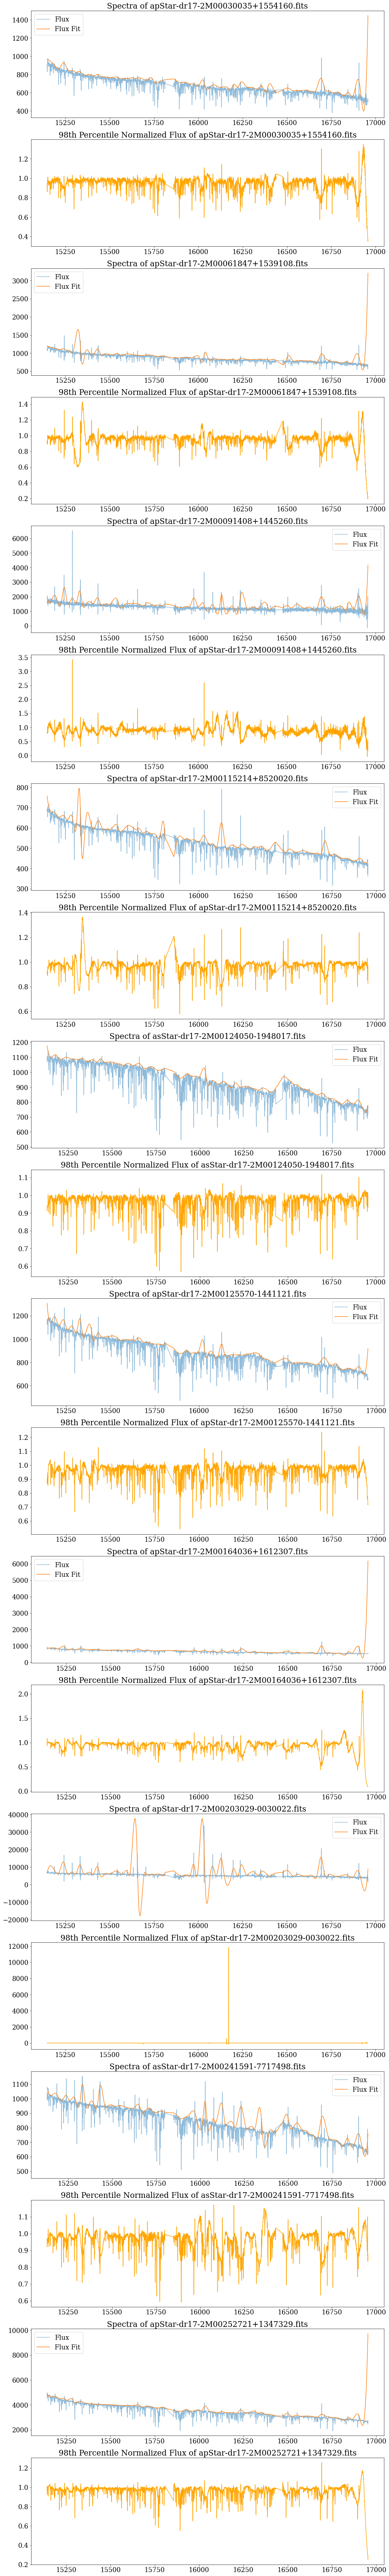

In [199]:
# flux normalization by the 50th percentile method

fig, axes = plt.subplots(20, figsize=(15,5*20), constrained_layout=True)
i = 0

for spec_file in spectra_10:
    # get the spectra for each star
    hdul = fits.open('../spectra/' + spec_file)
    sp = hdul[1].data # spectra are in the 1st extension
    wl_axis = reconstruct_wavelength_axis(hdul)
    
    # to exclude nan's from the flux array and get the corresponding wavelength array
    flux = sp[0][np.logical_not(np.isnan(sp[0]))] # sp[0] is the combined spectra with pixel-based weighting
    wl = wl_axis[np.logical_not(np.isnan(sp[0]))]
    
    flux_fit_50th, normalized_flux_50th = percentile_normalization(wl, flux, 100, 98)
    
    axes[i].plot(wl, flux, label='Flux', alpha=0.5)
    axes[i].plot(wl, flux_fit_50th, label='Flux Fit')
    axes[i].set_title('Spectra of ' + spec_file)
    axes[i].legend()
    axes[i+1].plot(wl, normalized_flux_50th, color='orange')
    axes[i+1].set_title('98th Percentile Normalized Flux of ' + spec_file)
    i += 2

#plt.savefig('../figures/10_spectra_normalized_98th.jpeg')

Individual spectra apStar-dr17-2M00030035+1554160.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00061847+1539108.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00091408+1445260.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00115214+8520020.fits has 14 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra asStar-dr17-2M00124050-1948017.fits has 3 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00125570-1441121.fits has 5 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00164036+1612307.fits has 2 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00203029-0030022.fits has 3 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra asStar-dr17-2M00241591-7717498.fits has 5 visits, CRVAL1 of 4.179 and CDELT1 of 6e-06
Individual spectra apStar-dr17-2M00252721+1347329.fits

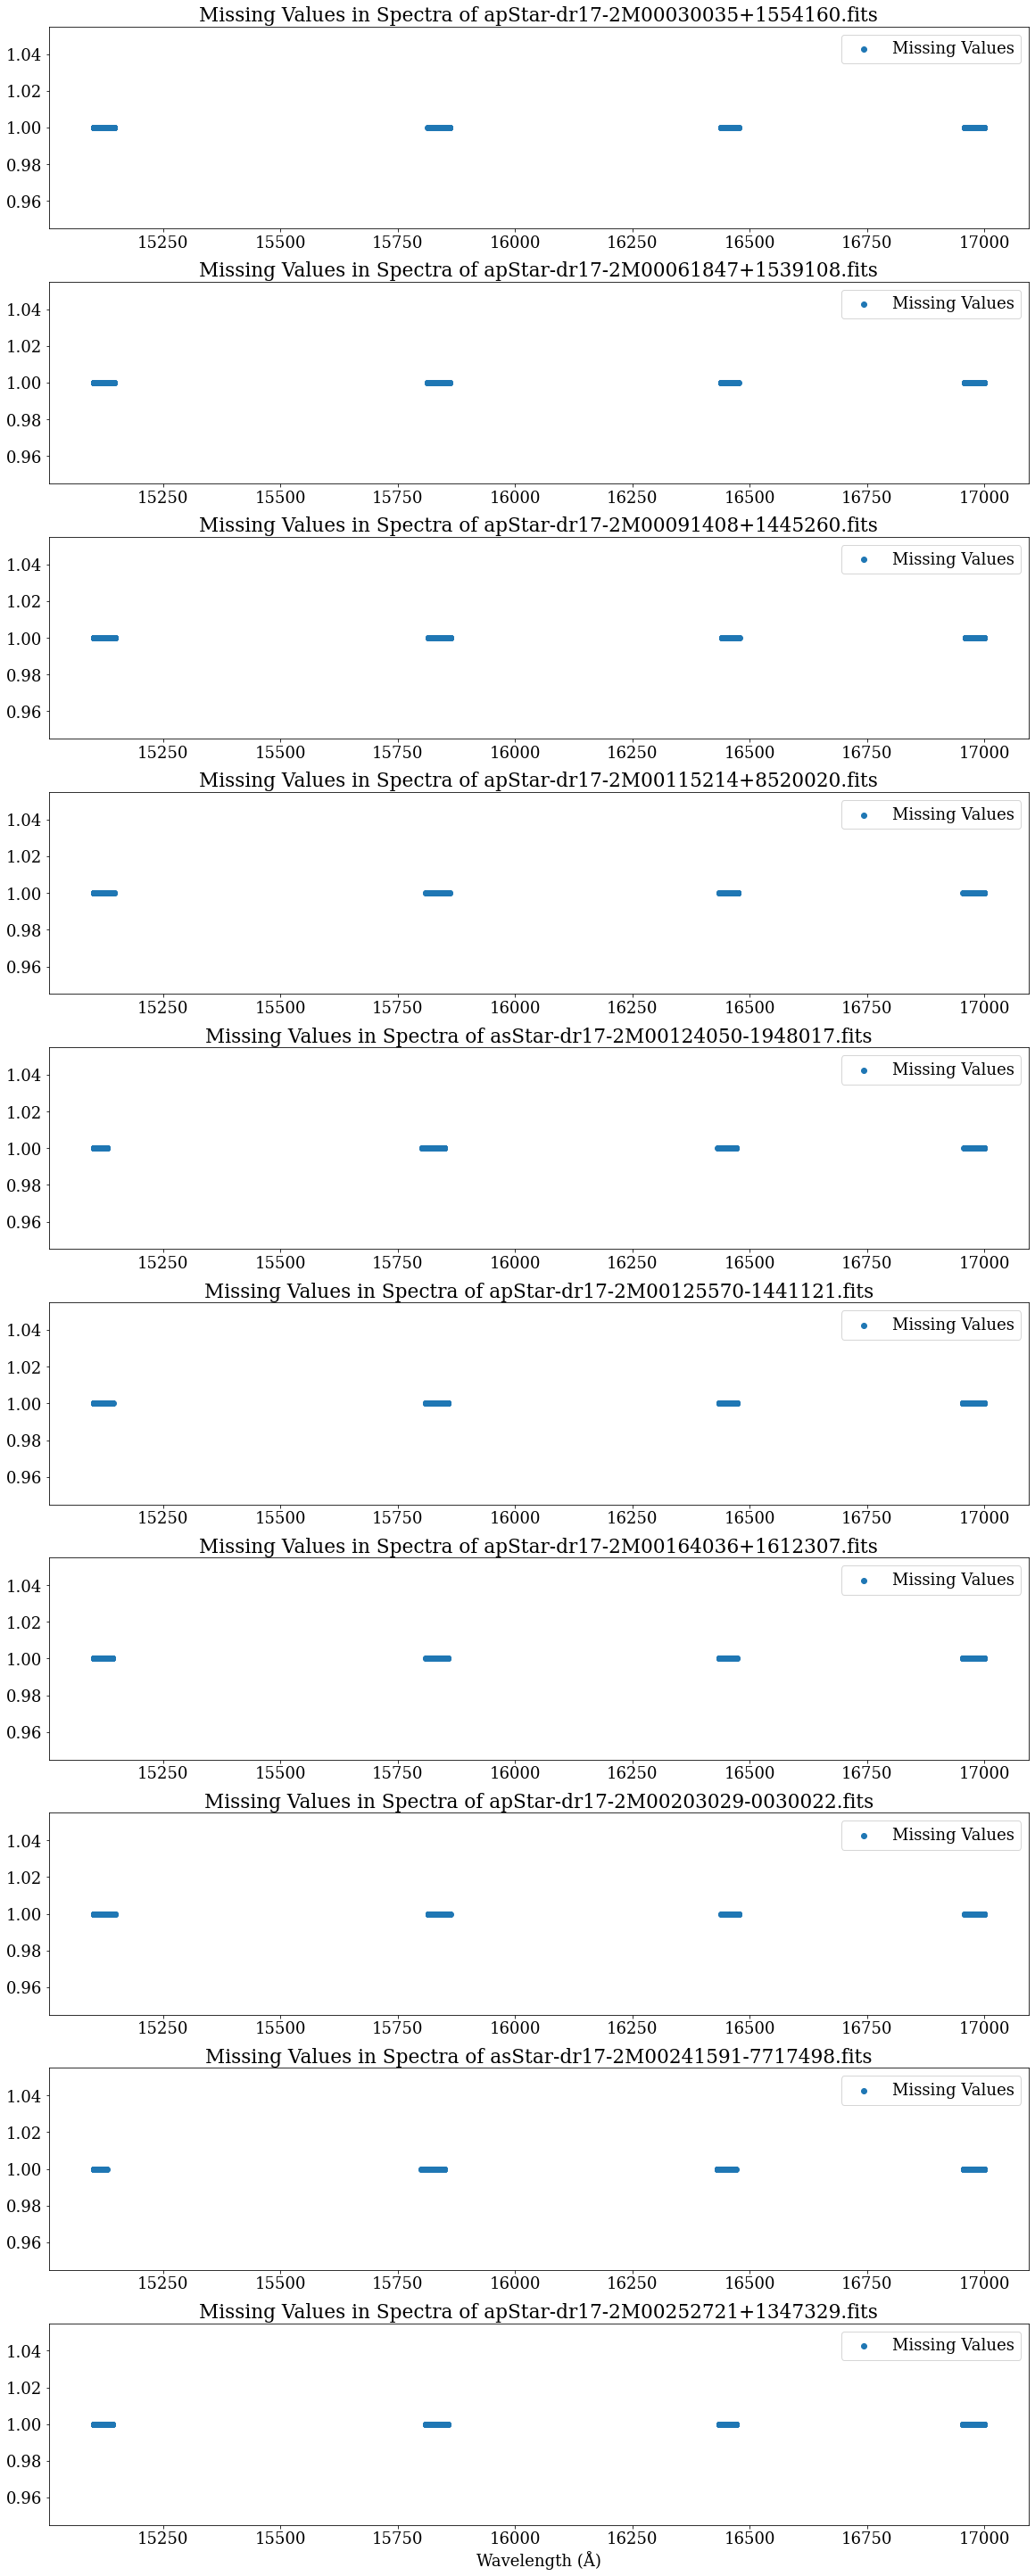

In [234]:
# plot missing values in each spectrum

fig, axes = plt.subplots(10, figsize=(16,4*10), constrained_layout=True)
plt.xlabel('Wavelength (Å)')
i = 0

for spec_file in spectra_10:
    # get the spectra for each star
    hdul = fits.open('../spectra/' + spec_file)
    sp = hdul[1].data # spectra are in the 1st extension
    wl_axis = reconstruct_wavelength_axis(hdul)
    
    missing_wl = wave[np.isnan(sp[0])]
    missing_flux_indicators = np.ones(len(wave[np.isnan(sp[0])]))
        
    axes[i].scatter(missing_wl, missing_flux_indicators, label="Missing Values")
    axes[i].set_title('Missing Values in Spectra of ' + spec_file)
    axes[i].legend()
    i += 1

#plt.savefig('../figures/10_spectra_missing_values.jpeg')

# Questions:
- What are the criteria to determine if a normalization method is good enough? How to compare multiple normalization methods?
- Why do we normalize spectra?
- Why does the spectrum decrease towards the end? Is it Planck's curve?
- What is deblazing? How is it different from normalizing?
- Why are there some ranges of missing values in the spectra?